## Hand Written Numbers Classifier using Convolutional Neural Networks (CNN)

Another classification example to recognize hand written numbers. Trained using MNIST dataset.

After training the model, you can use Sample_Sketching sketch in Processing to write numbers and see the results here.

In [ ]:
#install a required library to use OSC protocol
!pip install https://github.com/attwad/python-osc/archive/master.zip
!pip install matplotlib

In [2]:
#setup training data. Here we using MNIST dataset for numbers
# the training set is 28x28 input, and a number 0~9 as output

from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
import numpy as np
import PML

#load data
Train, Test = mnist.load_data()
samples=list(zip(Train[0],Train[1]))
sample_test=list(zip(Test[0],Test[1]))

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])
 
#Prepared to convolutional samples (3 channels per sample)
X,normalizer=PML.normalize_image(X)
x_train=PML.prepare_conv_samples(X)
#normalize values
nb_classes=10

#convert numbers output to one-hot encoding
y_train = utils.to_categorical(Train[1], nb_classes)
y_test = utils.to_categorical(Test[1], nb_classes)

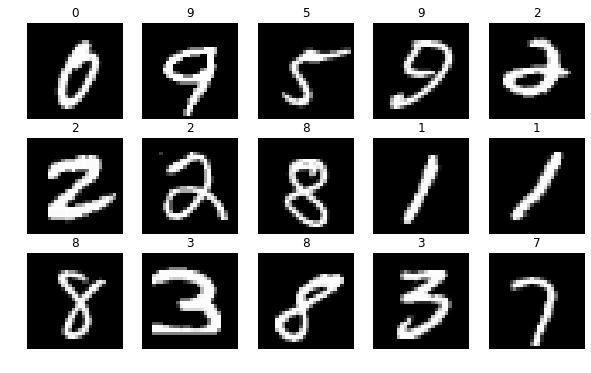

In [3]:
PML.plot_random_images(samples,labels=[0,1,2,3,4,5,6,7,8,9],rows=3,cols=5)

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 54000 samples
Validating using: 6000 samples


In [8]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

tensorboard = TensorBoard(log_dir="logs/MNIST_{}".format(time()))

TrainModel=True #Set to False to load pretrained model


model=PML.create_conv_classify_model(input_shape=(28,28,1),nbclasses=nb_classes,firstLayer=32,nlayers=[64,128],denseLayers=[64],dropout=0)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=20,batch_size=512, callbacks=[tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
__________

Model exported.


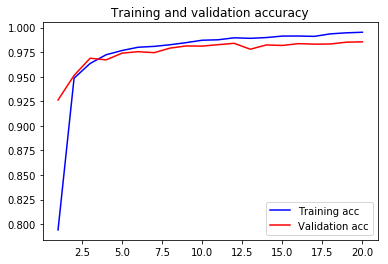

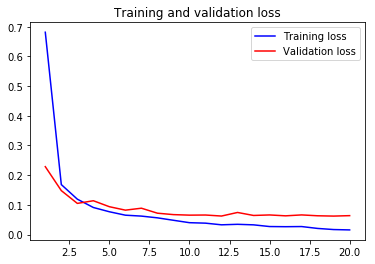

In [12]:
PML.export_model(model,"./models/mnist")

PML.plot_acc_loss(history)

In [11]:
train_labels=[0,1,2,3,4,5,6,7,8,9]

_=PML.test_samples(model,samples=sample_test,labels=train_labels,trainlabels=train_labels,normalizer=normalizer,flatten=False)

Accuracy for [0] is 99%
Accuracy for [1] is 100%
Accuracy for [2] is 99%
Accuracy for [3] is 100%
Accuracy for [4] is 100%
Accuracy for [5] is 99%
Accuracy for [6] is 99%
Accuracy for [7] is 99%
Accuracy for [8] is 99%
Accuracy for [9] is 99%


### setup OSC Protocol to communicate with Processing

In [14]:

import OSCHelper
server=OSCHelper.createServer(9000)

model=PML.import_model("./models/mnist")
model.summary()

Starting server on: 192.168.11.7:9000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12

In [ ]:
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image


def onOSC_Image(*args):
    width=args[1]
    height=args[2]
    jpgdata=args[3]
    file_jpgdata = io.BytesIO(jpgdata)
    img = Image.open(file_jpgdata).resize((28,28)).convert("L")
    img=255.0-np.array(img).astype(float)
    x=PML.prepare_conv_samples([normalizer.Normalize(img)])[0]
    plt.imshow(np.resize(x,(28,28)),cmap='gray')
    res=model.predict(np.array([x]))[0]
    for i,p in enumerate(res):
        print("[{0}]:{1}%".format(i,int(p*100)))
    plt.title("Prediction:{0}".format(np.argmax(res)))
    plt.show()

server.addMsgHandler( "/inputs/image", onOSC_Image )

OSCHelper.start_server(server)


In [40]:
server.close()
